# **Alphabet Inc. Pipeline**
This initial use cases looks at the pipeline for GOOG earnings from 2019.

# Imports

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance

import networkx as nx
import dowhy
import causalinference

# Earnings



Historical earnings dataset queried from [Dolthub](https://www.dolthub.com/repositories/post-no-preference/earnings)

In [2]:
df_earning_hist = pd.read_csv("goog_earning_hist.csv")
df_earning_hist['earning_date'] = pd.to_datetime(df_earning_hist['earning_date'],format='%m/%d/%y').dt.date
df_earning_hist['period_ending'] = pd.to_datetime(df_earning_hist['period_ending'], format='%m/%Y')
df_earning_hist['period_ending'] = df_earning_hist['period_ending'].apply(lambda d: d.replace(day=pd.Timestamp(d).days_in_month)).dt.date
df_earning_hist['estimate'] = df_earning_hist['estimate'].replace({'\$': '', ',': ''}, regex=True).astype(float)
df_earning_hist['reported'] = df_earning_hist['reported'].replace({'\$': '', ',': ''}, regex=True).astype(float)
df_earning_hist['surprise'] = df_earning_hist['surprise'].astype(float)
df_earning_hist['surprise_pct'] = df_earning_hist['surprise_pct'].replace({'%': '', ',': ''}, regex=True).astype(float)

In [3]:
df_earning_hist

,earning_date,period_ending,estimate,reported,surprise,surprise_pct,time
0,2025-02-04,2024-12-31,2.12,2.15,0.03,1.42,After Close
1,2024-10-29,2024-09-30,1.83,2.12,0.29,15.85,After Close
2,2024-07-23,2024-06-30,1.85,1.89,0.04,2.16,After Close
3,2024-04-25,2024-03-31,1.49,1.89,0.40,26.85,After Close
4,2024-01-30,2023-12-31,1.60,1.64,0.04,2.50,After Close
5,2023-10-24,2023-09-30,1.45,1.55,0.10,6.90,After Close
6,2023-07-25,2023-06-30,1.32,1.44,0.12,9.09,After Close
7,2023-04-25,2023-03-31,1.06,1.17,0.11,10.38,After Close
8,2023-02-02,2022-12-31,1.14,1.05,-0.09,-7.89,After Close
9,2022-10-25,2022-09-30,1.25,1.06,-0.19,-15.20,After Close


# Stock Prices

Historical stock data around earning dates extracted from yfinance with custom derived features

In [18]:
symbol = "GOOG"
stock_data = yf.Ticker(symbol)
historical_prices = stock_data.history(period="6y")
for days in range(1, 5):
    historical_prices[f'Close_prev_{days}D'] = historical_prices['Close'].shift(days)
historical_prices['Close_next_1D'] = historical_prices['Close'].shift(-1)

rolling_windows = [5, 7, 30]
for window in rolling_windows:
    historical_prices[f'Rolling_{window}D_Avg'] = historical_prices['Close'].rolling(window).mean()
    historical_prices[f'Rolling_{window}D_Std'] = historical_prices['Close'].rolling(window).std()

historical_prices['Daily_Price_Change'] = historical_prices['Close'].diff()
historical_prices['MACD'] = historical_prices['Close'].ewm(span=12, adjust=False).mean() - historical_prices['Close'].ewm(span=26, adjust=False).mean()
historical_prices['Bollinger_Upper'] = historical_prices['Close'].rolling(window=20).mean() + (2 * historical_prices['Close'].rolling(window=20).std())
historical_prices['Bollinger_Lower'] = historical_prices['Close'].rolling(window=20).mean() - (2 * historical_prices['Close'].rolling(window=20).std())

historical_prices.index = historical_prices.index.date

earnings_dates = df_earning_hist.earning_date
df_price = historical_prices.loc[historical_prices.index.isin(earnings_dates)]
df_price['date'] = df_price.index

<ipython-input-18-94346e4ee8c0>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_price['date'] = df_price.index


In [19]:
df_price

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Close_prev_1D,Close_prev_2D,Close_prev_3D,...,Rolling_5D_Std,Rolling_7D_Avg,Rolling_7D_Std,Rolling_30D_Avg,Rolling_30D_Std,Daily_Price_Change,MACD,Bollinger_Upper,Bollinger_Lower,date
2019-04-29,63.399712,64.159613,63.016278,64.075508,49988000,0.0,0.0,63.309143,62.874699,62.503952,...,0.596459,62.766779,0.819990,NaN,NaN,0.766365,1.031570,63.942522,58.289880,2019-04-29
2019-07-25,56.622806,56.815891,55.781792,56.339149,44196000,0.0,0.0,56.622307,57.040333,56.635254,...,0.312720,56.709896,0.343751,55.667151,1.209893,-0.283157,0.395682,58.372695,53.950141,2019-07-25
2019-10-28,63.471867,64.659244,63.327052,64.195938,52264000,0.0,0.0,62.958302,62.752274,62.659718,...,0.846993,62.629713,0.815455,61.182445,1.253976,1.237637,0.803719,64.160535,58.102123,2019-10-28
2020-02-03,72.755399,74.148800,72.605611,73.946754,60736000,0.0,0.0,71.373444,72.448845,72.587692,...,0.923910,72.427026,0.906228,70.398478,2.587809,2.573311,1.263241,74.955857,69.000503,2020-02-03
2020-04-28,64.092923,64.098892,61.319560,61.392712,59026000,0.0,0.0,63.493267,63.663960,63.514664,...,0.942098,62.641372,1.207710,58.898827,3.630143,-2.100555,0.730345,66.625579,54.747640,2020-04-28
2020-07-30,74.497149,76.531019,74.259277,76.211533,33428000,0.0,0.0,75.742249,74.663361,76.149323,...,0.652862,75.926448,1.081278,74.051557,2.580130,0.469284,1.052906,78.162605,73.009424,2020-07-30
2020-10-29,75.759167,79.309854,75.753199,77.992592,40062000,0.0,0.0,75.473518,79.834869,79.147614,...,2.296992,79.112501,1.965462,75.405726,3.183460,2.519073,0.927367,82.399361,71.467451,2020-10-29
2021-02-02,95.674835,97.327013,95.273241,95.921173,45474000,0.0,0.0,94.619331,91.354301,92.716347,...,2.086900,93.664503,1.939031,89.375791,3.453186,1.301842,1.833093,97.703815,83.736349,2021-02-02
2021-04-27,116.249396,116.321548,114.670372,114.812202,31972000,0.0,0.0,115.788574,115.219269,112.861443,...,1.127261,114.503375,0.934202,108.695884,5.630767,-0.976372,2.844400,119.558906,104.335327,2021-04-27
2021-07-27,139.350981,139.350981,134.463137,136.151627,42164000,0.0,0.0,138.986206,137.166321,132.699982,...,2.981765,133.729671,3.782419,128.955774,3.724771,-2.834579,3.004017,137.849958,123.145500,2021-07-27


# Macro Data

Macro Data considered incldue general market volatility, Tech sector performance, feds interest rates.

In [20]:
vix = yf.Ticker("^VIX")
vix_data = vix.history(period="6y")

for days in range(1, 5):
    vix_data[f'Close_prev_{days}D'] = vix_data['Close'].shift(days)

rolling_windows = [5, 7, 30]
vix_data['VIX_Change'] = vix_data['Close'].pct_change()
for window in rolling_windows:
    vix_data[f'Rolling_{window}D_Avg'] = vix_data['Close'].rolling(window).mean()
    vix_data[f'Rolling_{window}D_Std'] = vix_data['Close'].rolling(window).std()

vix_data.index = vix_data.index.date
df_vix = vix_data.loc[vix_data.index.isin(earnings_dates)]

In [21]:
df_vix

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Close_prev_1D,Close_prev_2D,Close_prev_3D,Close_prev_4D,VIX_Change,Rolling_5D_Avg,Rolling_5D_Std,Rolling_7D_Avg,Rolling_7D_Std,Rolling_30D_Avg,Rolling_30D_Std
2019-04-29,13.040000,13.270000,12.650000,13.110000,0,0.0,0.0,12.730000,13.250000,13.140000,12.280000,0.029851,12.902000,0.399212,12.717143,0.463671,NaN,NaN
2019-07-25,12.240000,13.540000,11.690000,12.740000,0,0.0,0.0,12.070000,12.610000,13.530000,14.450000,0.055510,13.080000,0.926823,13.271428,0.834075,14.080333,1.259635
2019-10-28,13.010000,13.140000,12.660000,13.110000,0,0.0,0.0,12.650000,13.710000,14.010000,14.460000,0.036364,13.588000,0.717928,13.741429,0.646128,15.739667,2.188047
2020-02-03,18.639999,18.879999,17.100000,17.969999,0,0.0,0.0,18.840000,15.490000,16.389999,16.280001,-0.046178,16.994000,1.369025,16.822857,1.567585,13.856667,1.909653
2020-04-28,33.209999,35.389999,30.540001,33.570000,0,0.0,0.0,33.290001,35.930000,41.380001,41.980000,0.008411,37.230000,4.195063,39.341429,4.994325,50.664000,12.719992
2020-07-30,25.040001,28.290001,24.639999,24.760000,0,0.0,0.0,24.100000,25.440001,24.740000,25.840000,0.027386,24.976000,0.676668,25.040000,0.758507,28.674333,3.330458
2020-10-29,38.799999,41.160000,35.630001,37.590000,0,0.0,0.0,40.279999,33.349998,32.459999,27.549999,-0.066782,34.245999,4.909698,32.569999,4.928208,28.413333,3.425069
2021-02-02,28.010000,28.080000,25.309999,25.559999,0,0.0,0.0,30.240000,33.090000,30.209999,37.209999,-0.154762,31.262000,4.283231,28.931428,5.298601,24.506333,3.698923
2021-04-27,17.620001,18.160000,16.969999,17.559999,0,0.0,0.0,17.639999,17.330000,18.709999,17.500000,-0.004535,17.748000,0.549700,17.815714,0.613048,18.419667,1.542037
2021-07-27,18.620001,20.440001,18.250000,19.360001,0,0.0,0.0,17.580000,17.200001,17.690001,17.910000,0.101251,17.948000,0.830163,18.852857,1.867331,17.303667,1.670025


In [22]:
qqq = yf.Ticker("QQQ")
qqq_data = qqq.history(period="6y")

for days in range(1, 5):
    qqq_data[f'Close_prev_{days}D'] = qqq_data['Close'].shift(days)

rolling_windows = [5, 7, 30]
qqq_data['QQQ_Change'] = qqq_data['Close'].pct_change()
for window in rolling_windows:
    qqq_data[f'Rolling_{window}D_Avg'] = qqq_data['Close'].rolling(window).mean()
    qqq_data[f'Rolling_{window}D_Std'] = qqq_data['Close'].rolling(window).std()

qqq_data.index = qqq_data.index.date
df_qqq = qqq_data.loc[qqq_data.index.isin(earnings_dates)]

In [23]:
df_qqq

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,Close_prev_1D,Close_prev_2D,Close_prev_3D,Close_prev_4D,QQQ_Change,Rolling_5D_Avg,Rolling_5D_Std,Rolling_7D_Avg,Rolling_7D_Std,Rolling_30D_Avg,Rolling_30D_Std
2019-04-29,183.446643,184.091341,183.148358,183.802673,21716200,0.0,0.0,0.0,183.446686,183.283066,182.542206,183.119507,0.001941,183.238828,0.464382,182.474827,1.366706,NaN,NaN
2019-07-25,187.555333,187.584262,186.050943,186.407761,23434700,0.0,0.0,0.0,188.191803,186.880295,185.665237,184.199417,-0.009480,186.268903,1.477989,186.035797,1.272218,182.850317,3.479567
2019-10-28,189.924125,191.160974,189.924125,190.909744,18818700,0.0,0.0,0.0,189.044785,187.547028,185.740067,185.382553,0.009865,187.724835,2.309931,187.246111,2.109623,184.094585,3.007921
2020-02-03,213.180043,215.843098,213.034791,215.349228,25408600,0.0,0.0,0.0,212.143936,215.562302,214.797256,214.448639,0.015109,214.460272,1.367828,214.166434,1.775591,211.117912,4.296192
2020-04-28,210.897676,210.897676,204.968241,205.249664,46862800,0.0,0.0,0.0,209.189713,207.520508,204.298630,204.735382,-0.018835,206.198779,2.082400,205.183140,3.276527,190.225098,14.133966
2020-07-30,250.558131,254.417509,249.401287,253.853683,41774500,0.0,0.0,0.0,252.531525,249.654053,252.871872,248.438919,0.005236,251.470010,2.305382,252.245507,3.011389,247.989518,7.472890
2020-10-29,265.392894,271.702041,264.926258,268.688446,43246300,0.0,0.0,0.0,264.070831,274.783813,272.654755,276.805725,0.017486,271.400714,5.082217,272.790863,4.780773,271.876436,8.002353
2021-02-02,316.984152,320.285649,316.818577,319.126709,33930800,0.0,0.0,0.0,314.004028,306.349182,312.932739,311.092010,0.016314,312.700934,4.636156,314.723306,5.126074,307.935606,6.314288
2021-04-27,333.425301,333.639830,330.733969,331.689575,33187200,0.0,0.0,0.0,333.132751,330.977722,326.862732,330.850983,-0.004332,330.702753,2.330346,330.286809,2.146715,320.136962,10.856628
2021-07-27,359.477890,359.477890,351.609250,355.777863,57933100,0.0,0.0,0.0,359.741547,359.458466,355.309296,352.976044,-0.011018,356.652643,2.894010,354.254953,4.868196,347.289385,7.752492


In [24]:
interest_rate = yf.Ticker("^IRX")
ir_data = interest_rate.history(period="6y")

ir_data.index = ir_data.index.date
df_ir = ir_data.loc[ir_data.index.isin(earnings_dates)]

In [25]:
df_ir

,Open,High,Low,Close,Volume,Dividends,Stock Splits
2019-04-29,2.360,2.365,2.360,2.360,0,0.0,0.0
2019-07-25,2.038,2.060,2.033,2.060,0,0.0,0.0
2019-10-28,1.630,1.635,1.603,1.605,0,0.0,0.0
2020-02-03,1.513,1.520,1.513,1.518,0,0.0,0.0
2020-04-28,0.103,0.103,0.083,0.085,0,0.0,0.0
2020-07-30,0.090,0.090,0.085,0.085,0,0.0,0.0
2020-10-29,0.083,0.085,0.083,0.083,0,0.0,0.0
2021-02-02,0.060,0.060,0.050,0.050,0,0.0,0.0
2021-04-27,0.010,0.010,0.008,0.010,0,0.0,0.0
2021-07-27,0.045,0.045,0.040,0.045,0,0.0,0.0


# Merged Dataset

In [31]:
df_vix = df_vix.add_prefix('vix_')
df_qqq = df_qqq.add_prefix('qqq_')
df_ir = df_ir.add_prefix('ir_')
df_vix = df_vix.reset_index().rename(columns={'index': 'date'})
df_qqq = df_qqq.reset_index().rename(columns={'index': 'date'})
df_ir = df_ir.reset_index().rename(columns={'index': 'date'})
df_earning_hist = df_earning_hist.rename(columns={'earning_date': 'date'})

In [35]:
merged_df = df_earning_hist.merge(df_price, on='date', how='left')
merged_df = merged_df.merge(df_vix, on='date', how='left')
merged_df = merged_df.merge(df_qqq, on='date', how='left')
merged_df = merged_df.merge(df_ir, on='date', how='left')

In [39]:
final_columns = [
    'date', 'estimate', 'reported', 'surprise', 'surprise_pct', 'time', 'Open', 'High', 'Low', 'Close','Volume',
    'Close_prev_1D', 'Close_prev_2D','Close_prev_3D', 'Close_prev_4D', 'Close_next_1D', 'Rolling_5D_Avg',
    'Rolling_5D_Std', 'Rolling_7D_Avg', 'Rolling_7D_Std', 'Rolling_30D_Avg',
    'Rolling_30D_Std', 'Daily_Price_Change', 'MACD', 'Bollinger_Upper','Bollinger_Lower',
    'vix_Close', 'vix_Volume', 'vix_Close_prev_1D', 'vix_Close_prev_2D', 'vix_Close_prev_3D', 'vix_Close_prev_4D',
    'vix_VIX_Change', 'vix_Rolling_5D_Avg', 'vix_Rolling_5D_Std','vix_Rolling_7D_Avg', 'vix_Rolling_7D_Std', 'vix_Rolling_30D_Avg', 'vix_Rolling_30D_Std',
    'qqq_Close', 'qqq_Volume', 'qqq_Close_prev_1D', 'qqq_Close_prev_2D', 'qqq_Close_prev_3D',
    'qqq_Close_prev_4D', 'qqq_QQQ_Change', 'qqq_Rolling_5D_Avg', 'qqq_Rolling_5D_Std', 'qqq_Rolling_7D_Avg', 'qqq_Rolling_7D_Std', 'qqq_Rolling_30D_Avg', 'qqq_Rolling_30D_Std',
    'ir_Close', 'ir_Volume'
]

merged_df = merged_df[final_columns]

In [40]:
merged_df

,date,estimate,reported,surprise,surprise_pct,time,Open,High,Low,Close,...,qqq_Close_prev_4D,qqq_QQQ_Change,qqq_Rolling_5D_Avg,qqq_Rolling_5D_Std,qqq_Rolling_7D_Avg,qqq_Rolling_7D_Std,qqq_Rolling_30D_Avg,qqq_Rolling_30D_Std,ir_Close,ir_Volume
0,2025-02-04,2.12,2.15,0.03,1.42,After Close,204.267279,208.462496,204.027547,207.473633,...,520.054504,0.012275,520.973083,2.418984,519.906110,3.467048,518.543286,7.512787,4.213,0
1,2024-10-29,1.83,2.12,0.29,15.85,After Close,169.000505,171.469893,168.277160,170.751526,...,486.847748,0.009608,492.781335,4.339498,493.173832,3.609381,487.296142,6.340319,4.480,0
2,2024-07-23,1.85,1.89,0.04,2.16,After Close,183.181575,184.556637,182.673407,182.942444,...,479.604218,-0.003525,477.730658,2.804920,482.383078,8.269179,481.668032,9.451711,5.173,0
3,2024-04-25,1.49,1.89,0.40,26.85,After Close,152.637040,157.533845,152.047836,157.205399,...,412.130890,-0.004830,419.336853,4.965966,420.110683,4.321249,433.702937,8.818845,5.245,0
4,2024-01-30,1.60,1.64,0.04,2.50,After Close,153.283972,154.309116,152.054794,152.328506,...,422.684052,-0.006656,422.741614,1.569240,421.810547,2.102750,408.271754,9.013440,5.203,0
5,2023-10-24,1.45,1.55,0.10,6.90,After Close,138.503991,140.046688,138.095921,139.459457,...,359.777252,0.009728,355.002930,3.482402,357.904528,5.723685,359.671576,6.355153,5.308,0
6,2023-07-25,1.32,1.44,0.12,9.09,After Close,121.305445,123.106918,120.957096,122.211159,...,381.285004,0.006778,374.324719,4.063143,375.896729,4.360257,365.923109,7.435112,5.265,0
7,2023-04-25,1.06,1.17,0.11,10.38,After Close,106.107431,106.933520,104.067092,104.116859,...,314.671051,-0.018864,311.509637,3.226120,312.452393,3.087215,308.960756,6.316868,4.953,0
8,2023-02-02,1.14,1.05,-0.09,-7.89,After Close,106.286575,108.307004,106.037754,108.287102,...,292.053467,0.035890,294.515985,8.070617,292.199903,7.849691,274.200238,12.857367,4.510,0
9,2022-10-25,1.25,1.06,-0.19,-15.20,After Close,102.813035,104.604545,102.534349,104.435349,...,266.012451,0.020686,270.974963,6.032372,269.536033,5.537541,271.697059,8.980377,3.965,0


# Simple Regression and Causal Graph

This is built on just Google earnings data for the past 6 years, there is a lot of correlation with companies in similar sectors, with similar growth trajectory, past reaction to earnings, etc. Hence, by aggregating these different companies' earnings data together, we can create a more reflective model. However, though using just 24 rows of Google dataset produce insignificant results, it is still implemented here to show what the pipeline would look like.

In [43]:
y = merged_df['Close_next_1D']
X = merged_df.drop(columns=['Close_next_1D', 'date', 'time'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

Mean Squared Error: 152.9720
R-Squared: 0.9044


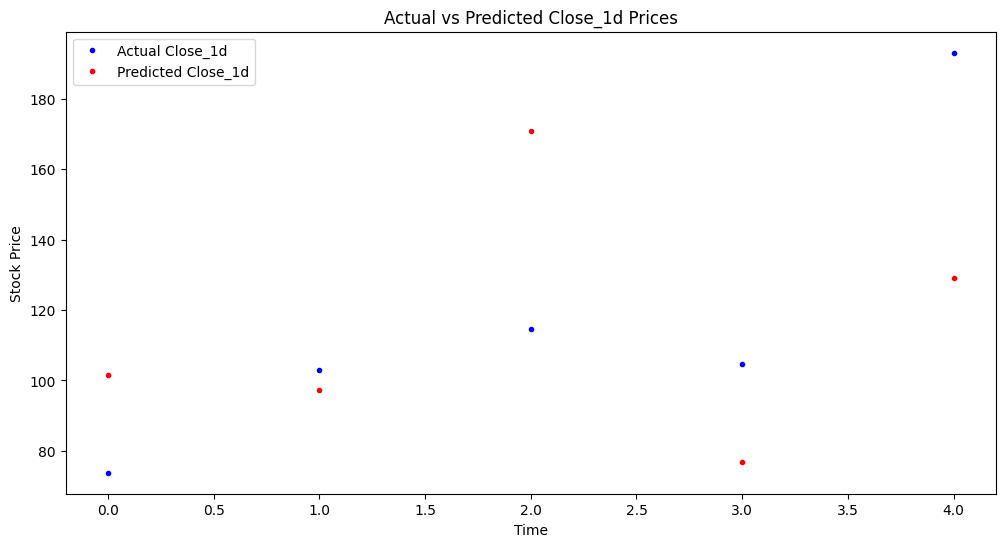

Mean Squared Error: 152.9720
R-Squared: 0.9044


In [57]:
if 'date' in merged_df.columns:
    X_test['date'] = merged_df.loc[X_test.index, 'date']
    X_test = X_test.sort_values('date')
    y_test = y_test.loc[X_test.index]
    y_pred = y_pred[np.argsort(X_test['date'])]

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, '.', label="Actual Close_1d", color='blue')
plt.plot(y_pred, '.', label="Predicted Close_1d", color='red')
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Close_1d Prices")
plt.legend()
plt.show()

print(f"Mean Squared Error: {mse:.4f}")
print(f"R-Squared: {r2:.4f}")

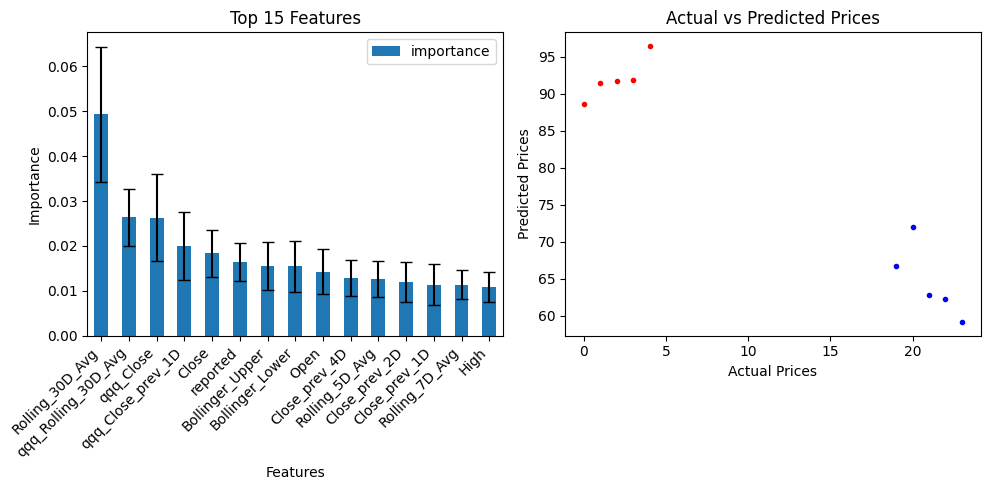

In [61]:
def advanced_stock_prediction_analysis(merged_df):
    exclude_cols = ['date', 'time', 'Close_next_1D']
    numeric_cols = [col for col in merged_df.columns if col not in exclude_cols]
    X = merged_df[numeric_cols]
    y = merged_df['Close_next_1D']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )

    tscv = TimeSeriesSplit(n_splits=5)

    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )

    cv_scores = cross_val_score(
        rf_model,
        X_train,
        y_train,
        cv=tscv,
        scoring='neg_mean_squared_error'
    )

    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)

    perm_importance = permutation_importance(
        rf_model,
        X_train,
        y_train,
        n_repeats=10,
        random_state=42
    )

    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': perm_importance.importances_mean,
        'std': perm_importance.importances_std
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    feature_importance.head(15).plot(x='feature', y='importance', kind='bar',
                                     yerr='std', ax=plt.gca(), capsize=4)
    plt.title('Top 15 Features')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    plt.subplot(1, 2, 2)
    plt.plot(y_pred, '.', label="Predicted Close_1d", color='red')
    plt.plot(y_test, '.', label="Actual Close_1d", color='blue')
    plt.title('Actual vs Predicted Prices')
    plt.xlabel("Time")
    plt.ylabel("Stock Price")

    plt.tight_layout()
    plt.show()

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return {
        'model': rf_model,
        'cv_scores': cv_scores,
        'feature_importance': feature_importance,
        'predictions': y_pred,
        'metrics': {
            'MSE': mse,
            'MAE': mae,
            'R2': r2
        }
    }

results = advanced_stock_prediction_analysis(merged_df)

In [62]:
print("Model Performance Metrics:")
for metric, value in results['metrics'].items():
    print(f"{metric}: {value:.4f}")

print("\nTop 10 Most Important Features:")
print(results['feature_importance'].head(10).to_string(index=False))

Model Performance Metrics:
MSE: 791.6451
MAE: 27.4224
R2: -39.3377

Top 10 Most Important Features:
            feature  importance      std
    Rolling_30D_Avg    0.049301 0.015068
qqq_Rolling_30D_Avg    0.026358 0.006272
          qqq_Close    0.026318 0.009664
  qqq_Close_prev_1D    0.019961 0.007504
              Close    0.018361 0.005223
           reported    0.016486 0.004271
    Bollinger_Upper    0.015514 0.005429
    Bollinger_Lower    0.015422 0.005774
               Open    0.014249 0.004990
      Close_prev_4D    0.012826 0.004053


In [ ]:
def create_causal_graph(df):
    G = nx.DiGraph()

    causal_edges = [] # TBD

    G.add_edges_from(causal_edges)
    return G

causal_graph = create_causal_graph(merged_df)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(causal_graph, k=0.5)
nx.draw(causal_graph, pos, with_labels=True, node_color='lightblue',
        node_size=1500, font_size=10, font_weight='bold')
plt.title("Potential Causal Relationships in Stock Price")